# Modelling of France Accidents

**Cohort:** mar23_accidents

**Author:** Tiago Russomanno

**Date:** 23 Oktober 2023

# Random forest using grav as target variable



## Loading of required libraries

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

## Importing the data

In [2]:
df = pd.read_csv('./data/231030_clean_table_for_analysis.csv', low_memory = False, index_col = 0)

## Data description
### Data

In [3]:
df.head()

,place,catu,grav,sexe,an_nais,trajet,locp,an,mois,jour,...,manv,date,is_holiday,holiday,datetime,actp,num_veh,etatp,day_of_week,hour_of_day
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,2.0,2,4,2,2002,0.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,4,2,1993,5.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,1,1,1959,0.0,-1.0,2019,11,30,...,11.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,0,0,5,1
201900000002,1.0,1,4,2,1994,0.0,-1.0,2019,11,30,...,0.0,2019-11-30,False,NaN,2019-11-30 02:50:00,0,0,0,5,2
201900000003,1.0,1,1,1,1996,0.0,-1.0,2019,11,28,...,2.0,2019-11-28,False,NaN,2019-11-28 15:15:00,1,0,0,3,15


### Data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 42 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  hrmn         object 
 11  lum          int64  
 12  agg          int64  
 13  int          int64  
 14  atm          float64
 15  col          float64
 16  dep          int64  
 17  catr         float64
 18  circ         float64
 19  nbv          float64
 20  vosp         float64
 21  prof         float64
 22  plan         float64
 23  surf         float64
 24  infra        float64
 25  situ         float64
 26  senc         float64
 27  catv         int64  
 28  occutc       float64
 29  obs          float64
 30  obsm         float64
 31  choc    

### Missing data

In [5]:
df.isna().sum()

place                0
catu                 0
grav                 0
sexe                 0
an_nais              0
trajet               0
locp                 0
an                   0
mois                 0
jour                 0
hrmn                 0
lum                  0
agg                  0
int                  0
atm                  0
col                  0
dep                  0
catr                 0
circ                 0
nbv                  0
vosp                 0
prof                 0
plan                 0
surf                 0
infra                0
situ                 0
senc                 0
catv                 0
occutc               0
obs                  0
obsm                 0
choc                 0
manv                 0
date                 0
is_holiday           0
holiday        2367768
datetime             0
actp                 0
num_veh              0
etatp                0
day_of_week          0
hour_of_day          0
dtype: int64

This data has no missing values, accept the `holiday` variable which contains the name of the holiday or NaN.

### Drop variables
The dataset contains still some variables that represent information represented by other variables or are a finer granulation. The latter might be added later, if the primary variable is relevant.

- `holiday`: classifies the holiday, but will be used only, if `is_holiday` is relevant

In [6]:
columns_drop = ['holiday', 'hrmn', 'datetime']

df.drop(columns = columns_drop, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  lum          int64  
 11  agg          int64  
 12  int          int64  
 13  atm          float64
 14  col          float64
 15  dep          int64  
 16  catr         float64
 17  circ         float64
 18  nbv          float64
 19  vosp         float64
 20  prof         float64
 21  plan         float64
 22  surf         float64
 23  infra        float64
 24  situ         float64
 25  senc         float64
 26  catv         int64  
 27  occutc       float64
 28  obs          float64
 29  obsm         float64
 30  choc         float64
 31  manv    

## Data preparation
### Transform data types
#### Date and time variables
The date and time variables are maybe important as grouping variables or as contrains for time dependent severity of accidents.

_Problem_:

Due to the export to `csv`, the `datatime` data time is lost and thus, it is required to assign it again.

**Steps:**
1. Transform `date` and `hrmn` to `datetime` type.nais` to integer and `date` to `date`.

In [8]:
# Fixing the hrmn issue:
# Transform `date`
#df = df.assign(date = pd.to_datetime(df['date'])) old version
#df = df.assign(hrmn = pd.to_datetime(df['hrmn'])) old version

df = df.assign(date = pd.to_datetime(df['date']))
df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)

In [9]:
#df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1) old version
#df['hrmn'] = df.apply(lambda x: int(x['hrmn'].timestamp()), axis = 1) old version

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  lum          int64  
 11  agg          int64  
 12  int          int64  
 13  atm          float64
 14  col          float64
 15  dep          int64  
 16  catr         float64
 17  circ         float64
 18  nbv          float64
 19  vosp         float64
 20  prof         float64
 21  plan         float64
 22  surf         float64
 23  infra        float64
 24  situ         float64
 25  senc         float64
 26  catv         int64  
 27  occutc       float64
 28  obs          float64
 29  obsm         float64
 30  choc         float64
 31  manv    

## Data analysis
### Correlation matrix
To get a first glimpse on the possible contrains in the data, a correlation matrix is plotted.

The data variables are dropped to remove redundany with `timestamp`.

In [10]:
# Drop date columns for the correlation matrix
columns_drop = ['an', 'mois', 'jour']#'hrmn'] #, 'date']
df_select = df.drop(columns_drop, axis = 1)

In [11]:
# Scale the data
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_select), columns=df_select.columns)

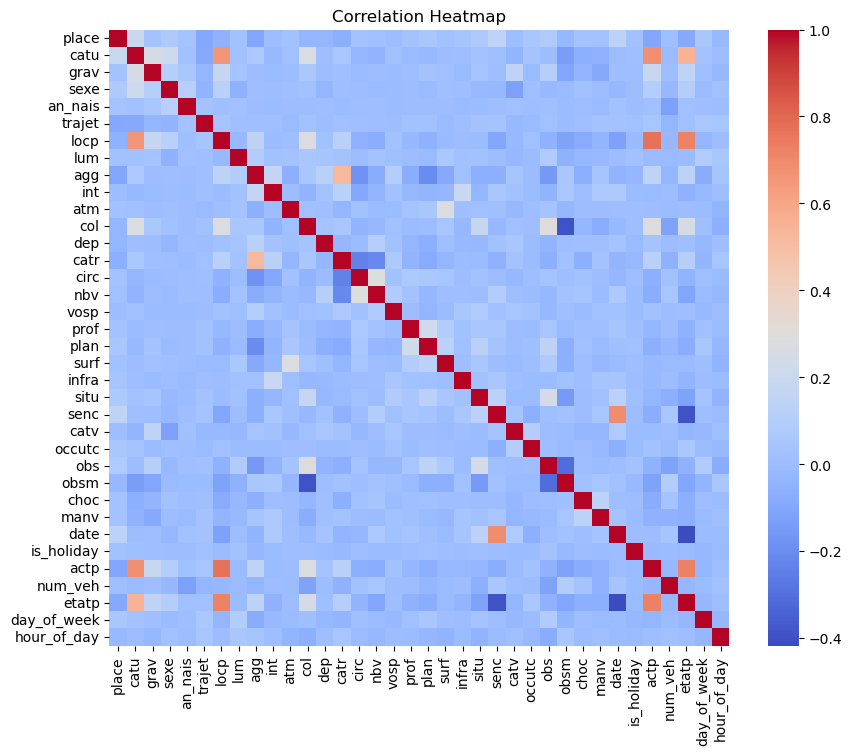

In [12]:
# Create a correlation matrix
correlation_matrix = df_numeric_scaled.corr()
plt.figure(figsize=(10, 8))
# Generate the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show();

The correlation matrix shows some intervariable correlations.
The idea is to explore the variable gravity of the accidents as a possible target variable. 

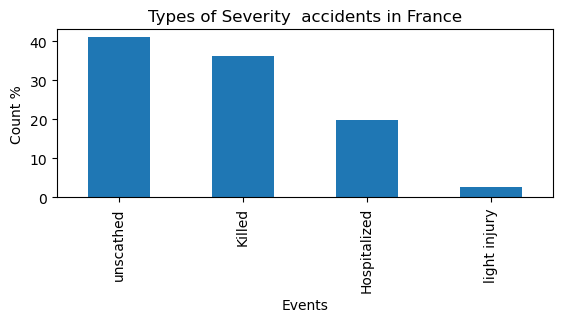

In [14]:
event_counts = df['grav'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(2,1,1)
event_percentages.plot.bar()
labels = ['unscathed','Killed','Hospitalized','light injury']
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Types of Severity  accidents in France')
# Display the plot
plt.show()

### Preparation of the training and test datasets
#### Split data
The dataset is split by year slides. The years 2005 to 2019 are selected for the train dataset and the years 2020 and 2021 for the test dataset.


In [15]:
# split the dataset to train and test data
X_train = df.loc[df['an'] < 2020].drop('grav', axis = 1)
X_test = df.loc[df['an'] > 2019].drop('grav', axis = 1)

y_train = df['grav'].loc[df['an'] < 2020]
y_test = df['grav'].loc[df['an'] > 2019]


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


#### Data scaling
Decision trees are not sensitive to different scales and thus scaling is not required.

### Modelling the data using a Randon Forest classifier with 100 estimators

In [16]:
# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = clf.predict(X_test)

# Get the accuracy score
acc = accuracy_score(y_test, y_pred)

# Model Accuracy, how often is the classifier correct?
print("[Random Forest Algorithm] Accuracy Score: {:.3f}".format(acc))

# Print the classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

[Random Forest Algorithm] Accuracy Score: 0.671
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77     92891
           1       0.48      0.03      0.06      5485
           2       0.51      0.40      0.45     33445
           3       0.64      0.68      0.66     89390

    accuracy                           0.67    221211
   macro avg       0.59      0.48      0.48    221211
weighted avg       0.66      0.67      0.66    221211



[Random Forest Algorithm] Accuracy Score: 0.669
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77     92891
           1       0.40      0.03      0.05      5485
           2       0.51      0.40      0.45     33445
           3       0.64      0.68      0.66     89390

    accuracy                           0.67    221211
   macro avg       0.57      0.47      0.48    221211
weighted avg       0.66      0.67      0.66    221211

In [17]:
from sklearn.metrics import confusion_matrix
#  confusion matrix
matrix = confusion_matrix(y_test, y_pred)  #y_test_preds

# Create a DataFrame from the confusion matrix
class_names = df.grav.values
dataframe = pd.DataFrame(matrix, index=['0', '1','2','3'], 
                         columns=['0', '1','2','3'])

# Display the confusion matrix as text
print("Confusion Matrix:")
print(dataframe)

Confusion Matrix:
       0    1      2      3
0  74106   17   2151  16617
1    653  161   2875   1796
2   4121  133  13242  15949
3  20957   26   7482  60925


Length of feature_names: 38
Length of importances: 38


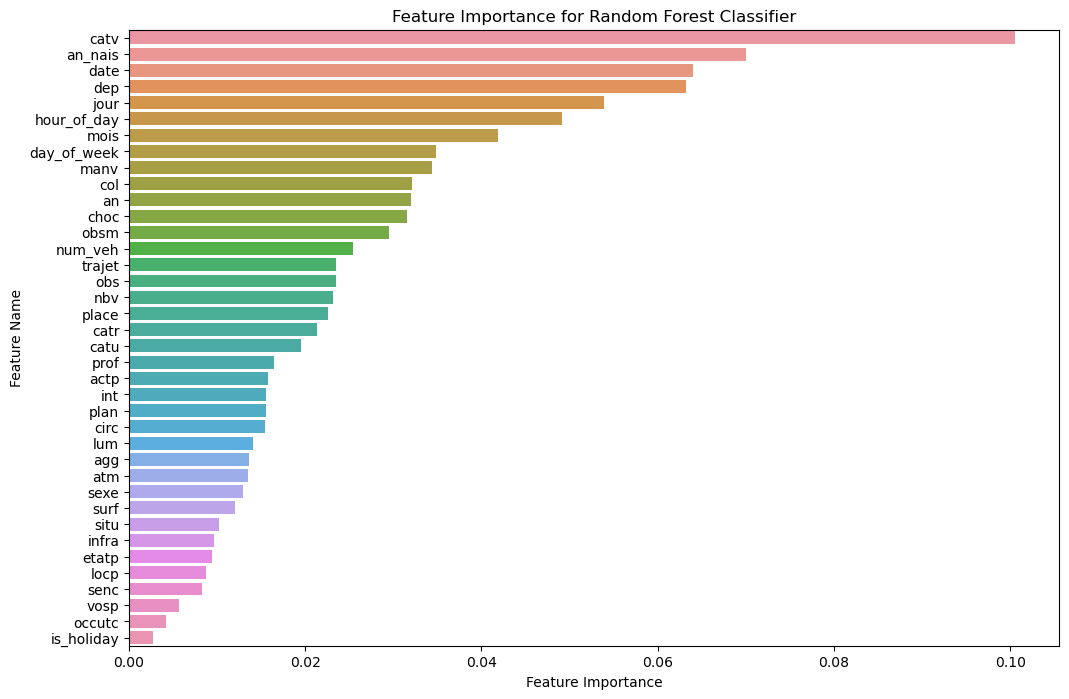

In [18]:
# estimate the feature importance for the model
import numpy as np

# Access feature importances from the trained model
importances = clf.feature_importances_

feature_names = df.drop(columns=['grav']).columns.tolist()

# Check the lengths of feature_names and importances
print("Length of feature_names:", len(feature_names))
print("Length of importances:", len(importances))

# Create a DataFrame to hold feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance for Random Forest Classifier')
plt.show()

In [19]:
from sklearn.tree import export_text
tree_index = 0
decision_tree = clf.estimators_[tree_index]

tree_text = export_text(decision_tree,feature_names=feature_names)
print(tree_text)

|--- locp <= 0.50
|   |--- catv <= 25.50
|   |   |--- place <= 1.50
|   |   |   |--- catv <= 6.50
|   |   |   |   |--- locp <= -0.50
|   |   |   |   |   |--- trajet <= 4.50
|   |   |   |   |   |   |--- occutc <= -0.50
|   |   |   |   |   |   |   |--- num_veh <= 7.00
|   |   |   |   |   |   |   |   |--- col <= 3.50
|   |   |   |   |   |   |   |   |   |--- dep <= 91.50
|   |   |   |   |   |   |   |   |   |   |--- manv <= 9.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |   |--- manv >  9.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |   |   |   |   |   |--- dep >  91.50
|   |   |   |   |   |   |   |   |   |   |--- situ <= 4.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- situ >  4.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 3.0
|   |   |   |   |   |   |   |   |--- col >  3.50
|

### saving the model for future use

In [20]:
import joblib
joblib.dump(clf, 'random_forest_model_3b.pkl')

['random_forest_model_3b.pkl']

### load the model 

#####  loaded_model = joblib.load('random_forest_model_3b.pkl')